## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\ProgramData\Anaconda3\envs\tensorflow_cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

# def build_mlp():
#     """
#     Build your own model
#     """
#     return model
from keras.regularizers import l1, l2, l1_l2

In [6]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2=[1e-2, 1e-4, 1e-8, 1e-12]

In [9]:
results = {}
"""
Set your training loop
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 307us/step - loss: 6.0110 - acc: 0.2802 - val_loss: 5.8089 - val_acc: 0.3540
Epoch 2/50
50000/50000 [==============================] - 15s 298us/step - loss: 5.7194 - acc: 0.3719 - val_loss: 5.6483 - val_acc: 0.3813
Epoch 3/50
50000/50000 [==============================] - 15s 298us/step - loss: 5.5711 - acc: 0.4004 - val_loss: 5.5082 - val_acc: 0.4106
Epoch 4/50
50000/50000 [==============================] - 15s 299us/step - loss: 5.4500 - acc: 0.4190 - val_loss: 5.4070 - val_acc: 0.4265
Epoch 5/50
50000/50000 [==============================] - 15s 298us/step - loss: 5.3424 - acc: 0.4348 - val_loss: 5.3021 - val_acc: 0.4331
Epoch 6/50
50000/50000 [==============================] - 15s 305us/step - loss: 5.2425 - acc: 0.4465 - val_loss: 5.2095 - val_acc: 0.4415
Epoch 7/50
50000/50000 [==============================] - 15s 303us/step - loss: 5.1491 - acc: 0.4570 - val_loss: 5.

50000/50000 [==============================] - 15s 307us/step - loss: 2.0012 - acc: 0.2874 - val_loss: 1.8334 - val_acc: 0.3653
Epoch 2/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.7848 - acc: 0.3723 - val_loss: 1.7360 - val_acc: 0.3962
Epoch 3/50
50000/50000 [==============================] - 15s 295us/step - loss: 1.7072 - acc: 0.4027 - val_loss: 1.6835 - val_acc: 0.4142
Epoch 4/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.6499 - acc: 0.4225 - val_loss: 1.6267 - val_acc: 0.4329
Epoch 5/50
50000/50000 [==============================] - 15s 294us/step - loss: 1.6018 - acc: 0.4382 - val_loss: 1.5877 - val_acc: 0.4409
Epoch 6/50
50000/50000 [==============================] - 15s 298us/step - loss: 1.5632 - acc: 0.4523 - val_loss: 1.5534 - val_acc: 0.4523
Epoch 7/50
50000/50000 [==============================] - 15s 291us/step - loss: 1.5278 - acc: 0.4662 - val_loss: 1.5382 - val_acc: 0.4587
Epoch 8/50
50000/50000 [==============

Epoch 2/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.7937 - acc: 0.3701 - val_loss: 1.7602 - val_acc: 0.3750
Epoch 3/50
50000/50000 [==============================] - 15s 291us/step - loss: 1.7134 - acc: 0.3998 - val_loss: 1.6895 - val_acc: 0.3965
Epoch 4/50
50000/50000 [==============================] - 15s 292us/step - loss: 1.6566 - acc: 0.4214 - val_loss: 1.6340 - val_acc: 0.4236
Epoch 5/50
50000/50000 [==============================] - 15s 291us/step - loss: 1.6087 - acc: 0.4374 - val_loss: 1.5978 - val_acc: 0.4367
Epoch 6/50
50000/50000 [==============================] - 15s 295us/step - loss: 1.5693 - acc: 0.4499 - val_loss: 1.5693 - val_acc: 0.4411.5699 -
Epoch 7/50
50000/50000 [==============================] - 15s 294us/step - loss: 1.5370 - acc: 0.4618 - val_loss: 1.5470 - val_acc: 0.4505
Epoch 8/50
50000/50000 [==============================] - 15s 292us/step - loss: 1.5075 - acc: 0.4705 - val_loss: 1.5194 - val_acc: 0.4637
Epoch 9/50
50000/500

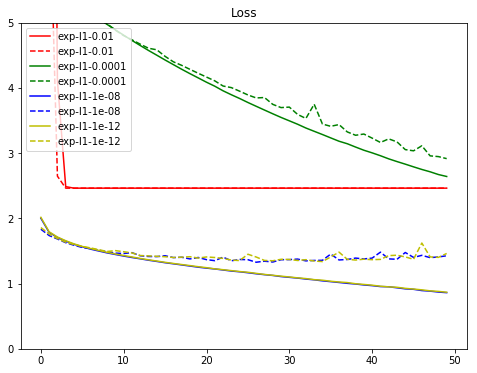

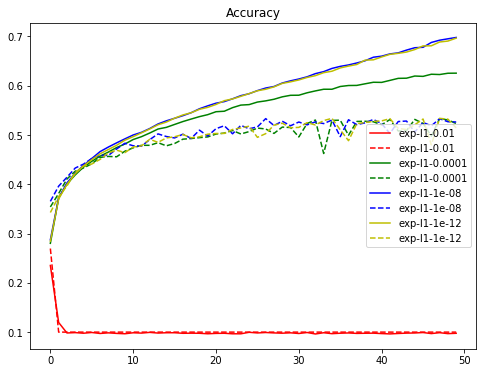

In [10]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# """
# plot the results
# """
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
results = {}
"""
Set your training loop
"""
for regulizer_ratio in L1_L2:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 337us/step - loss: 18.8029 - acc: 0.2787 - val_loss: 17.3640 - val_acc: 0.3373
Epoch 2/50
50000/50000 [==============================] - 16s 325us/step - loss: 16.1436 - acc: 0.3600 - val_loss: 14.9757 - val_acc: 0.3809
Epoch 3/50
50000/50000 [==============================] - 16s 327us/step - loss: 13.9582 - acc: 0.3811 - val_loss: 12.9709 - val_acc: 0.3870
Epoch 4/50
50000/50000 [==============================] - 16s 327us/step - loss: 12.1078 - acc: 0.3957 - val_loss: 11.2675 - val_acc: 0.4046
Epoch 5/50
50000/50000 [==============================] - 16s 323us/step - loss: 10.5359 - acc: 0.4030 - val_loss: 9.8272 - val_acc: 0.4132
Epoch 6/50
50000/50000 [==============================] - 16s 321us/step - loss: 9.1974 - acc: 0.4132 - val_loss: 8.5908 - val_acc: 0.4175
Epoch 7/50
50000/50000 [==============================] - 16s 325us/step - loss: 8.0595 - acc: 0.4192 - val

50000/50000 [==============================] - 17s 340us/step - loss: 15.1040 - acc: 0.2680 - val_loss: 13.9718 - val_acc: 0.3322
Epoch 2/50
50000/50000 [==============================] - 16s 320us/step - loss: 13.0366 - acc: 0.3562 - val_loss: 12.1508 - val_acc: 0.3595
Epoch 3/50
50000/50000 [==============================] - 16s 324us/step - loss: 11.3598 - acc: 0.3815 - val_loss: 10.6073 - val_acc: 0.3802
Epoch 4/50
50000/50000 [==============================] - 16s 321us/step - loss: 9.9441 - acc: 0.3942 - val_loss: 9.3082 - val_acc: 0.3985
Epoch 5/50
50000/50000 [==============================] - 16s 322us/step - loss: 8.7413 - acc: 0.4055 - val_loss: 8.1952 - val_acc: 0.4151
Epoch 6/50
50000/50000 [==============================] - 16s 321us/step - loss: 7.7170 - acc: 0.4125 - val_loss: 7.2536 - val_acc: 0.4166
Epoch 7/50
50000/50000 [==============================] - 16s 326us/step - loss: 6.8433 - acc: 0.4175 - val_loss: 6.4599 - val_acc: 0.4210
Epoch 8/50
50000/50000 [========

Epoch 2/50
50000/50000 [==============================] - 16s 322us/step - loss: 13.0353 - acc: 0.3512 - val_loss: 12.1625 - val_acc: 0.3556
Epoch 3/50
50000/50000 [==============================] - 16s 328us/step - loss: 11.3631 - acc: 0.3782 - val_loss: 10.6108 - val_acc: 0.3858
Epoch 4/50
50000/50000 [==============================] - 16s 321us/step - loss: 9.9482 - acc: 0.3921 - val_loss: 9.3087 - val_acc: 0.4018
Epoch 5/50
50000/50000 [==============================] - 16s 323us/step - loss: 8.7442 - acc: 0.4020 - val_loss: 8.2092 - val_acc: 0.4054
Epoch 6/50
50000/50000 [==============================] - 17s 334us/step - loss: 7.7215 - acc: 0.4104 - val_loss: 7.2578 - val_acc: 0.4099
Epoch 7/50
50000/50000 [==============================] - 16s 326us/step - loss: 6.8479 - acc: 0.4180 - val_loss: 6.4534 - val_acc: 0.4209
Epoch 8/50
50000/50000 [==============================] - 16s 321us/step - loss: 6.1031 - acc: 0.4245 - val_loss: 5.7677 - val_acc: 0.4262
Epoch 9/50
50000/50000 

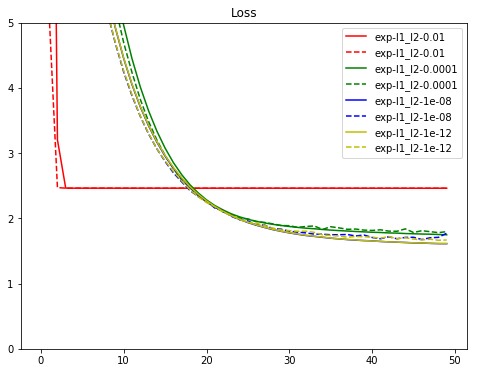

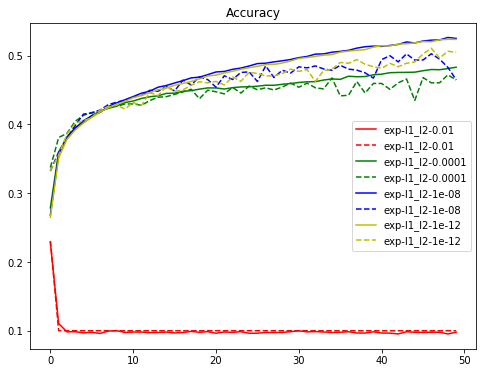

In [12]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()